<a href="https://colab.research.google.com/github/PragyaKumari2203/Image-Captioning-Model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-requisites

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Image-Captioning-Model

/content/drive/MyDrive/Image-Captioning-Model


In [3]:
# Install dependencies (optional, if already installed)
# !pip install -r requirements.txt

# **Data Preparation**




In [3]:
import os
import torch
from torch import nn
from transformers import BertTokenizerFast, BertModel
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import numpy as np
import random
from transformers import get_cosine_schedule_with_warmup
from torch.amp import autocast, GradScaler

In [4]:
PATH_TO_CAPTIONS = "./Flickr8k_text/Flickr8k.token.txt"
PATH_TO_IMAGES = "./Flickr8k_Dataset"
PATH_TO_TRAINING_DATA = "./Flickr8k_text/Flickr_8k.trainImages.txt"
PATH_TO_VALIDATION_DATA = "./Flickr8k_text/Flickr_8k.devImages.txt"
PATH_TO_TEST_DATA = "./Flickr8k_text/Flickr_8k.testImages.txt"

## Loading image-caption pairs

In [5]:
def load_captions(filename):
  captions = {}
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      parts = line.strip().split('\t')
      if len(parts) < 2:
        continue
      jpg_filename, caption = parts[0] .split('#')[0], parts[1]
      if jpg_filename not in captions:
        captions[jpg_filename] = []
      captions[jpg_filename].append(caption)
  return captions

## Fine-tuning Huggingface tokenizer on Flickr8K dataset

In [43]:
model_name = "bert-base-uncased"
berttokenizer = BertTokenizerFast.from_pretrained(model_name)

captions = load_captions(PATH_TO_CAPTIONS)
all_captions = [cap for caps in captions.values() for cap in caps]

tokenizer = berttokenizer.train_new_from_iterator(all_captions, vocab_size=15000)

tokenizer.save_pretrained("flickr8k-custom-tokenizer")
tokenizer = BertTokenizerFast.from_pretrained("flickr8k-custom-tokenizer")

In [44]:
print("Vocab size of custom tokenizer:", tokenizer.vocab_size)

Vocab size of custom tokenizer: 12767


## Image and text preprocessing

In [45]:
def tokenize(caption,max_length = 30):
  tokens = tokenizer(
      caption,
      max_length = max_length,
      padding = "max_length",
      truncation = True,
      return_tensors = "pt"
  )
  return tokens.input_ids.squeeze(0), tokens.attention_mask.squeeze(0)

def image_transforms():
    return transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

## Writing Custom Dataset

In [46]:
class Flickr8kDataset(Dataset):
  def __init__(self,image_dir,captions_dict,image_filenames,tokenizer=None,transform=None,max_length=30):
    """
        Args:
            image_dir (str): Path to the directory containing images.
            captions_dict (dict): Dictionary mapping image filenames to a list of captions.
            image_filenames (list): List of image filenames for this dataset split (train/val/test).
            tokenizer: Hugging Face tokenizer for captions.
            transform: Image transformations.
            max_length (int): Maximum token length for captions, default = 30.
    """
    self.image_dir = image_dir
    self.captions_dict = captions_dict
    self.image_filenames = image_filenames
    self.tokenizer = tokenizer
    self.transform = transform
    self.max_length = max_length

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self,idx):
    image_filename = self.image_filenames[idx]
    image_path = os.path.join(self.image_dir,image_filename)
    image = Image.open(image_path).convert("RGB")

    if self.transform:
      image = self.transform(image)

    captions = self.captions_dict[image_filename]
    caption_sel = captions[torch.randint(0,len(captions),(1,)).item()]
    input_ids, attention_mask = self.tokenizer(caption_sel, self.max_length)

    return image, input_ids, attention_mask

In [47]:
def image_list(filepath):
  with open(filepath,'r') as f:
    return [line.strip() for line in f.readlines()]

training_data = image_list(PATH_TO_TRAINING_DATA)
validation_data = image_list(PATH_TO_VALIDATION_DATA)
test_data = image_list(PATH_TO_TEST_DATA)

print(f"Number of training images: {len(training_data)}")
print(f"Number of validation images: {len(validation_data)}")
print(f"Number of test images: {len(test_data)}")

Number of training images: 6000
Number of validation images: 1000
Number of test images: 1000


In [48]:
captions = load_captions(PATH_TO_CAPTIONS)

example_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = training_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

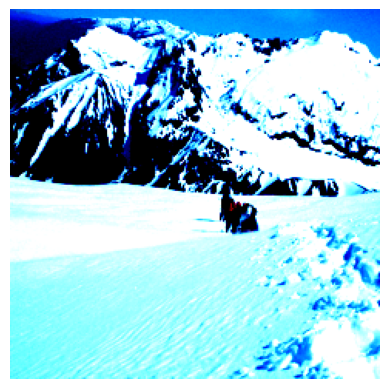

Tokenized IDs: tensor([   2,   29,  917,  117,  189,  156,  913,  400, 1653,  229,  206,  573,
         785,   14,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
Input IDs to text: [CLS] a line of people are making their way through snow covered mountains. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Input IDs to tokens: ['[CLS]', 'a', 'line', 'of', 'people', 'are', 'making', 'their', 'way', 'through', 'snow', 'covered', 'mountains', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [49]:
fig = plt.figure()
image, input_ids, attention_mask = example_dataset[30]
plt.imshow(image.permute(1,2,0))
plt.axis('off')
plt.show()

print(f"Tokenized IDs: {input_ids}")
print(f"Input IDs to text: {tokenizer.decode(input_ids)}")
print(f"Input IDs to tokens: {tokenizer.convert_ids_to_tokens(input_ids)}")

## Creating dataloaders

In [50]:
training_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = training_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

valid_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = validation_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

test_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = test_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

In [51]:
train_dataloader = DataLoader(training_dataset,batch_size = 32,shuffle = True, num_workers = 2)
valid_dataloader = DataLoader(valid_dataset,batch_size = 32,shuffle = False,num_workers = 2)
test_dataloader = DataLoader(test_dataset,batch_size = 32,shuffle = False,num_workers = 2)

In [52]:
for batch in train_dataloader:
    images, input_ids, attn_masks = batch
    print(f"Batch Image Shape: {images.shape}")
    print(f"Batch Token Shape: {input_ids.shape}")
    print(f"Batch Attention Mask Shape: {attn_masks.shape}")
    break

Batch Image Shape: torch.Size([32, 3, 240, 240])
Batch Token Shape: torch.Size([32, 30])
Batch Attention Mask Shape: torch.Size([32, 30])


# Model Architecture

## Model definition

In [53]:
class Encoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.cnn = models.efficientnet_b1(weights='DEFAULT')
        self.cnn.classifier = nn.Identity()
        self.out_channels = self.cnn.features[-1][0].out_channels
        self.projection = nn.Sequential(
            nn.Linear(self.out_channels, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        for name, param in self.cnn.named_parameters():
          if not any(f"blocks.{i}" in name for i in [6, 7]):
              param.requires_grad = False

    def forward(self, images):
        # images = [batch_size,3,240,240]

        # features = [batch_size,1280]
        features = self.cnn(images)
        # projection = [batch_size,embed_dim]
        return self.projection(features)

In [54]:
class Decoder(nn.Module):
    def __init__(self, embed_dim, vocab_size):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        for name, param in self.bert.named_parameters():
          if not any(f"encoder.layer.{i}" in name for i in [10, 11]) and "embeddings" not in name:
              param.requires_grad = False
        self.token_embeddings = self.bert.embeddings.word_embeddings
        self.dropput = nn.Dropout(0.3)
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, input_ids, attention_mask, image_embeds):
        # image_embeds: [batch_size, embed_dim]
        # input_ids: [batch_size, seq_len]
        # attention_mask: [batch_size,seq_len]

        batch_size = input_ids.size(0)
        seq_length = input_ids.size(1)
        # extended_attention_mask = [batch_size,seq_len + 1]
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, 1, device=input_ids.device),
            attention_mask
        ], dim=1)
        # text_embeds = [batch_size,seq_len,embed_dim]
        text_embeds = self.token_embeddings(input_ids)
        # input_embeds = [batch_size,seq_len + 1,embed_dim]
        inputs_embeds = torch.cat([
            image_embeds.unsqueeze(1),
            text_embeds
        ], dim=1)
        # outputs = [batch_size,seq_len+1,embed_dim]
        outputs = self.bert(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_attention_mask,
            return_dict=True
        )
        # text_output = [batch_size,seq_len,embed_dim]
        text_output = outputs.last_hidden_state[:, 1:, :]
        text_output = self.dropput(text_output)
        # output_layer = [batch_size,seq_len,vocab_size]
        return self.output_layer(text_output)

In [55]:
class ImageCaptioningModel(nn.Module):
  def __init__(self,embed_dim,vocab_size):
    super(ImageCaptioningModel,self).__init__()
    self.encoder = Encoder(embed_dim)
    self.decoder = Decoder(embed_dim,vocab_size)

  def forward(self,images,input_ids,attention_mask):
    # images = [batch_size,3,240,240]
    # input_ids = [batch_size,seq_length]
    # attention_mask = [batch_size,seq_length]

    # image_features = [batch_size,embed_dim]
    image_features = self.encoder(images)
    # output = [batch_size,seq_length,vocab_size]
    outputs = self.decoder(input_ids, attention_mask, image_features)
    return outputs

# Training the model

## Model initialization

In [56]:
config = {
    'batch_size': 32,
    'embed_dim': 768,
    'learning_rate': 1e-3,
    'epochs': 10,
    'max_length': 30,
    'temperature': 1.2,
    'top_k': 50,
    'weight_decay': 0.01,
    'warmup': 0.1,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_steps = len(train_dataloader) * config['epochs']
warmup_steps = int(config['warmup'] * total_steps)

model = ImageCaptioningModel(embed_dim=config['embed_dim'],
                             vocab_size=tokenizer.vocab_size).to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, label_smoothing=0.1)

In [57]:
def print_trainable_params(model):
    print("Trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

print_trainable_params(model.encoder)
print_trainable_params(model.decoder)

Trainable parameters:
projection.0.weight
projection.0.bias
Trainable parameters:
bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.10.attention.self.query.weight
bert.encoder.layer.10.attention.self.query.bias
bert.encoder.layer.10.attention.self.key.weight
bert.encoder.layer.10.attention.self.key.bias
bert.encoder.layer.10.attention.self.value.weight
bert.encoder.layer.10.attention.self.value.bias
bert.encoder.layer.10.attention.output.dense.weight
bert.encoder.layer.10.attention.output.dense.bias
bert.encoder.layer.10.attention.output.LayerNorm.weight
bert.encoder.layer.10.attention.output.LayerNorm.bias
bert.encoder.layer.10.intermediate.dense.weight
bert.encoder.layer.10.intermediate.dense.bias
bert.encoder.layer.10.output.dense.weight
bert.encoder.layer.10.output.dense.bias
bert.encoder.layer.10.output.LayerNorm.weight
ber

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 48,814,559 trainable parameters


## Training and evaluation loops

In [59]:
def train_fn(model, dataloader, optimizer, criterion, scheduler, device):
    model.train()
    total_loss = 0.0

    for images, captions, attention_masks in dataloader:
        images = images.to(device)
        captions = captions.to(device)
        attention_masks = attention_masks.to(device)
        optimizer.zero_grad()
        outputs = model(images, captions[:, :-1], attention_masks[:, :-1])
        loss = criterion(
            outputs.reshape(-1, outputs.size(-1)),
            captions[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluation_fn(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, captions, attention_masks in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            attention_masks = attention_masks.to(device)
            outputs = model(images, captions[:, :-1], attention_masks[:, :-1])
            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                captions[:, 1:].reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

## Caption generation and model training

In [60]:
print(f"Training on: {device}")

Training on: cuda


In [61]:
def generate_caption(model, image_path, tokenizer, device, max_length, temperature, top_k):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = image_transforms()
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_embed = model.encoder(image_tensor)

    input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
    generated_ids = []

    for _ in range(max_length):
        attention_mask = torch.ones_like(input_ids)
        with torch.no_grad():
            outputs = model.decoder(input_ids, attention_mask, image_embed)
            next_token_logits = outputs[:, -1, :] / temperature

            if top_k > 0:
                indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                next_token_logits[indices_to_remove] = -float('Inf')

            probs = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)

        if next_token_id.item() == tokenizer.sep_token_id:
            break

        generated_ids.append(next_token_id.item())
        input_ids = torch.cat([input_ids, next_token_id], dim=1)

    caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return caption

In [ ]:
best_val_loss = float('inf')
for epoch in range(config['epochs']):
    train_loss = train_fn(model, train_dataloader, optimizer, criterion, scheduler, device)
    val_loss = evaluation_fn(model, valid_dataloader, criterion, device)

    print(f"Epoch {epoch+1}/{config['epochs']}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), "saved_model.pth")
      print("Saved new best model")

    # Test generation
    test_image = random.choice(test_data)
    test_path = os.path.join(PATH_TO_IMAGES, test_image)
    caption = generate_caption(model, test_path, tokenizer, device, config['max_length'], config['temperature'], config['top_k'])
    print(f"Sample Generation: {caption}\n")

# Model evaluation and inference

In [ ]:
model.load_state_dict(torch.load("saved_model.pth"))
test_loss = evaluation_fn(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")

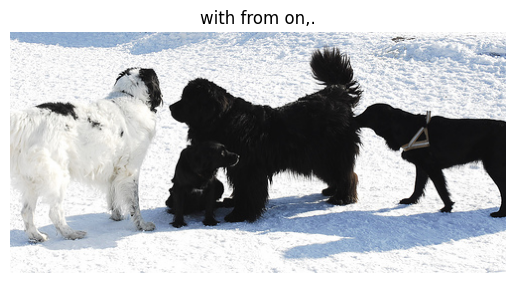

Caption: with from on,.


In [48]:
test_image = random.choice(test_data)
test_image_path = os.path.join(PATH_TO_IMAGES,test_image)
caption = generate_caption(model, test_image_path, tokenizer, device, config['max_length'], config['temperature'], config['top_k'])

image = Image.open(test_image_path)
plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()
print("Caption:", caption)